In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import tinyarray
import plotly
import cmath

In [27]:
def get_eigen_energies(sys: kwant.builder.FiniteSystem, n_max = None, plot = False, dic = dict()):
    if n_max is None:
        n_max = len(list(sys.sites)) - 2
    for b in [1]:
        h = sys.hamiltonian_submatrix(params=dic, sparse=True)
        enrgies = sla.eigsh(h.tocsc(), k=n_max, return_eigenvectors=False, which="SM")
        if plot:
            plt.scatter(range(len(enrgies)), sorted(enrgies), label="B = " + str(b))
    plt.xlabel('Index')
    plt.ylabel('Energy')
    plt.title('Eigenenergies')
    plt.show()
    return enrgies

In [28]:
def get_eigen_energies_and_vectors(sys: kwant.builder.FiniteSystem, n, n_max=None, plot=False, axis = None, dic = dict()):
    if n_max is None:
        n_max = len(list(sys.sites)) - 2
    h = sys.hamiltonian_submatrix(params=dic, sparse=True)
    energies, vectors = sla.eigsh(h.tocsc(), k=n_max, which="SM")
    energies_sort = np.argsort(np.real(energies))
    vectors = vectors.T
    energies = energies[energies_sort]
    vectors = vectors[energies_sort]
    if axis is not None: plot = True
    if plot: kwant.plotter.map(sys, np.abs(vectors[n])**2, oversampling=5, show=False, ax=axis)
    return energies, vectors

# Hexagonal systems

In [29]:
# get my preffered arctan funciton:

def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:
    
        if ans < 0: return 2*np.pi + ans
        else: return ans
    
    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans
    
    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    # create system

    def magnetic_field_hoppings(site1, site2, B):
        x0, y0 = site1.pos
        x1, y1 = site2.pos
        m, b = (x1 - x0)/(y1 - y0), x0 - y0*(x1 - x0)/(y1 - y0)
        phi = B*m*(y1*y1 - y0*y0)/2 + B*b*(y1- y0)
        return -2.8*np.exp(1j*phi)
    
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = 0 # onsite energies are set to 0
    sys[lat.neighbors()] = magnetic_field_hoppings
    a_lat, b_lat = lat.sublattices
    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]
    # make sure that no lattice point is connected to more than one site
    return sys



## Zig-zag

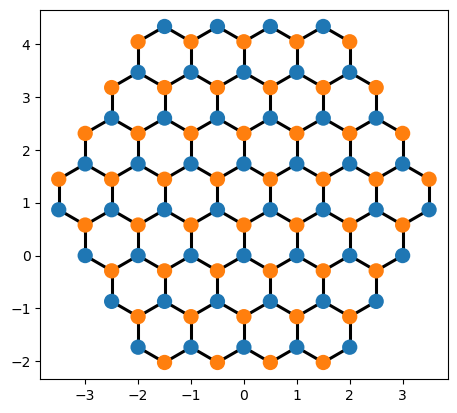

In [30]:
sys1 = create_graphene_hexagonal_system(4, start=0)
kwant.plot(sys1)
plt.show()

In [31]:
len(list(sys1.sites()))

96

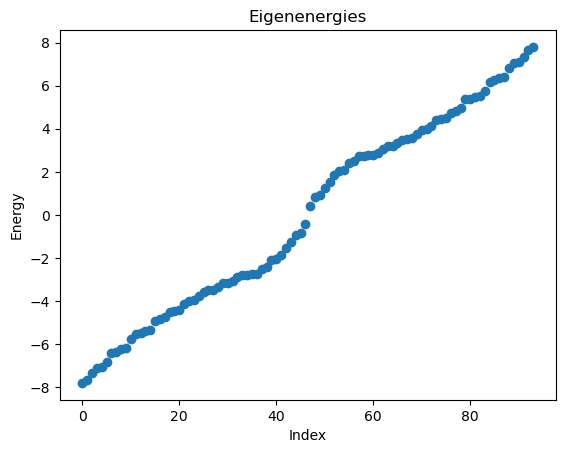

In [37]:
energies = get_eigen_energies(sys1.finalized(), plot=True, dic = dict(B = 0.1))

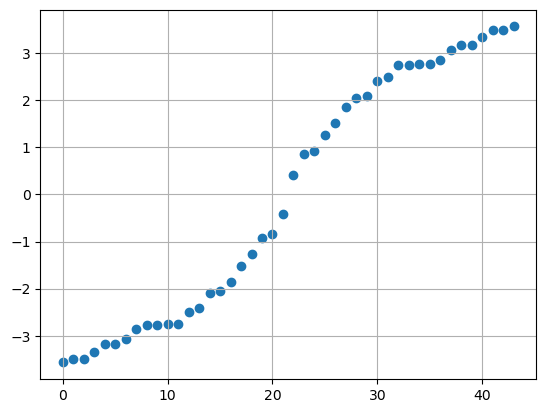

In [38]:
ens = energies[50:]
plt.scatter(list(range(len(ens))), np.sort(ens))
plt.grid()
plt.show()

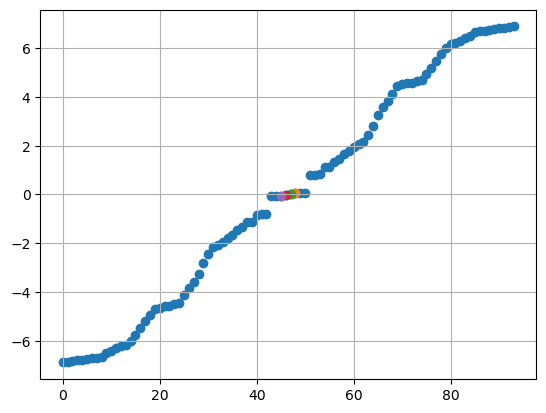

In [40]:
edge_esHzz, edge_vecsHzz = get_eigen_energies_and_vectors(sys1.finalized(), 200, dic = dict(B = 10))
plt.scatter(list(range(len(edge_esHzz))), edge_esHzz)
plt.scatter(48, edge_esHzz[48])
plt.scatter(47, edge_esHzz[47])
plt.scatter(46, edge_esHzz[46])
plt.scatter(45, edge_esHzz[45])
plt.grid()
plt.show()

In [41]:
edge_vecsHzz.shape

(94, 96)

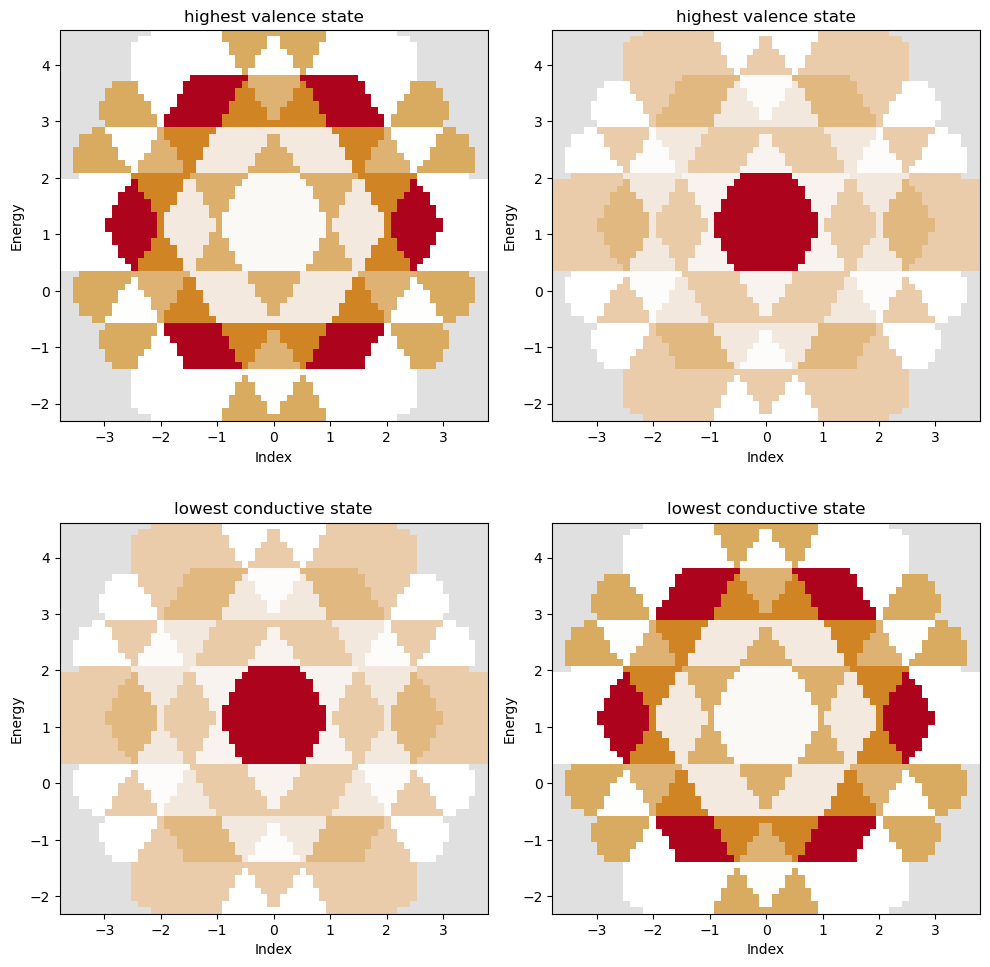

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# _, _ = get_eigen_energies_and_vectors(sys1.finalized(), 48, axis=axs[0, 0])
kwant.plotter.map(sys1.finalized(), np.abs(edge_vecsHzz[48])**2, oversampling=5, show=False, ax=axs[0, 0])
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Energy')
axs[0, 0].set_title('highest valence state')

# _, _ = get_eigen_energies_and_vectors(sys1.finalized(), 47, axis=axs[0, 1])
kwant.plotter.map(sys1.finalized(), np.abs(edge_vecsHzz[47])**2, oversampling=5, show=False, ax=axs[0, 1])
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Energy')
axs[0, 1].set_title('highest valence state')


# _, _ = get_eigen_energies_and_vectors(sys1.finalized(), 46, axis=axs[1, 0])
kwant.plotter.map(sys1.finalized(), np.abs(edge_vecsHzz[46])**2, oversampling=5, show=False, ax=axs[1, 0])
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Energy')
axs[1, 0].set_title('lowest conductive state')


# _, _ = get_eigen_energies_and_vectors(sys1.finalized(), 45, axis=axs[1, 1])
kwant.plotter.map(sys1.finalized(), np.abs(edge_vecsHzz[45])**2, oversampling=5, show=False, ax=axs[1, 1])
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Energy')
axs[1, 1].set_title('lowest conductive state')

plt.tight_layout()
plt.show()

# Triangular systems

In [16]:
# get my preffered arctan funciton:
def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:
    
        if ans < 0: return 2*np.pi + ans
        else: return ans
    
    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans
    
    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_tiangular_system(r, B = 0, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = 0 # onsite energies are set to 0
    # for s in kwant.builder.HoppingKind((0, 0), a_lat, b_lat)(sys):
    #     s1, s2 = s
    #     phi = s1.pos[0]*(s2.pos[1] - s1.pos[1])
    #     sys[s] = -2.8*np.exp(1j*phi*B)

    # for s in kwant.builder.HoppingKind((0, 1), a_lat, b_lat)(sys):
    #     s1, s2 = s
    #     phi = a*s1.pos[0]/2/np.sqrt(3) + np.sqrt(3)/2*(s2.pos[1] - s1.pos[1])*(s2.pos[1] - s1.pos[1])
    #     sys[s] = -2.8*np.exp(1j*phi*B)

    # for s in kwant.builder.HoppingKind((-1, 1), a_lat, b_lat)(sys):
    #     s1, s2 = s
    #     phi = a*np.sqrt(3)/24*(4*s1.pos[0] + a)
    #     sys[s] = -2.8*np.exp(1j*phi*B)
    
    def magnetic_field_hoppings(site1, site2, B):
        x0, y0 = site1.pos
        x1, y1 = site2.pos
        m, b = (x1 - x0)/(y1 - y0), x0 - y0*(x1 - x0)/(y1 - y0)
        phi = B*m*(y1*y1 - y0*y0)/2 + B*b*(y1- y0)
        return -2.8*np.exp(1j*phi)
    # Choose a specific site

    sys[lat.neighbors()] = magnetic_field_hoppings

    # Count the number of connections (hopping terms) for the site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    # make sure that no lattice point is connected to more than one site
    return sys


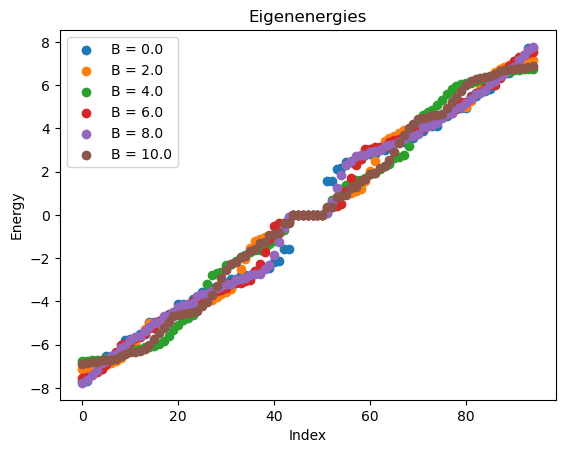

In [17]:
def plot_energies_trzz(n_max = None, plot = False,):

    for b in np.linspace(0, 10, 6):
        sys = create_graphene_tiangular_system(r = 6.5, B = b, start=np.pi/2, a=1.0).finalized()
        if n_max is None and b == 0:
            n_max = len(list(sys.sites)) - 2
        h = sys.hamiltonian_submatrix(params=dict(B = b), sparse=True)
        enrgies = sla.eigsh(h.tocsc(), k=n_max, return_eigenvectors=False, which="SM")
        if plot:
            plt.scatter(range(len(enrgies)), sorted(enrgies), label="B = " + str(b))
    
    plt.xlabel('Index')
    plt.ylabel('Energy')
    plt.title('Eigenenergies')
    plt.legend()
    plt.show()
plot_energies_trzz(plot=True)

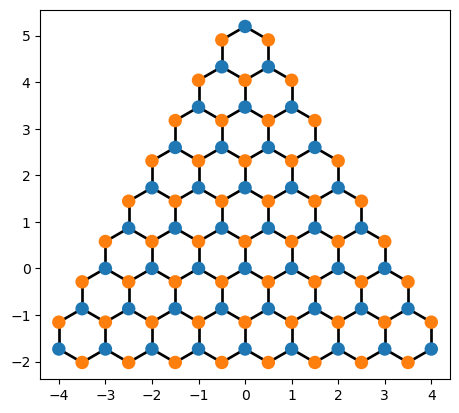

In [86]:
sys_t_zz = create_graphene_tiangular_system(6.5, start = np.pi/2, a = 1.0)
kwant.plot(sys_t_zz)
plt.show()

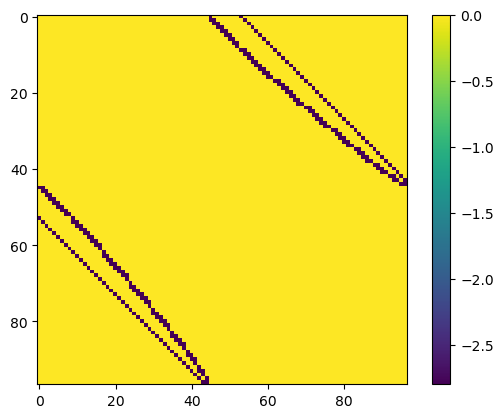

In [87]:
h = sys_t_zz.finalized().hamiltonian_submatrix(params = dict(B = 1.5), sparse = True).tocsc()
plt.imshow(np.real(h.toarray()))
plt.colorbar()
plt.show()

In [88]:
len(list(sys_t_zz.sites()))

97

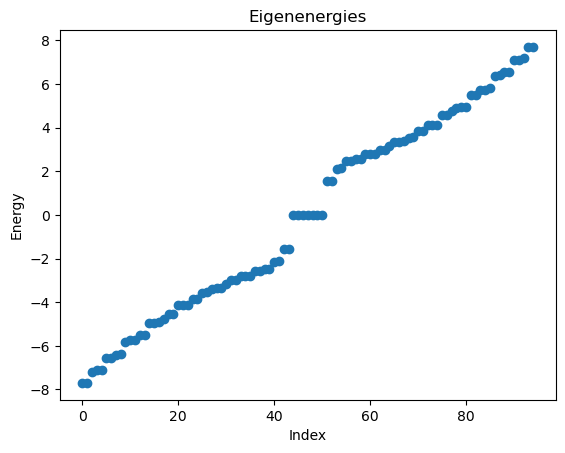

In [89]:
energies_t_zz = get_eigen_energies(sys_t_zz.finalized(), plot=True)

In [10]:
np.save("graphene_tr_zz_noSOC.npy", energies_t_zz)

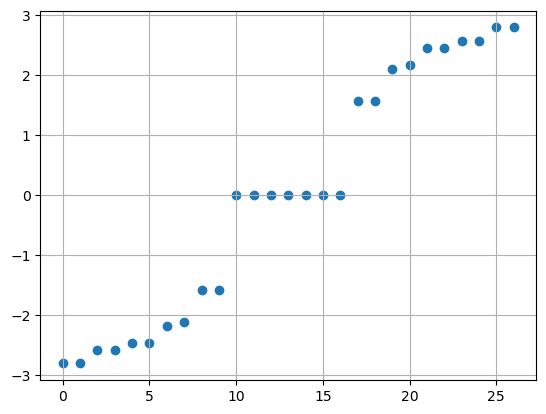

In [11]:
enstzz = energies_t_zz[68:] # unfortunatly not 69
plt.scatter(list(range(len(enstzz))), np.sort(enstzz))
plt.grid()
plt.show()

$N_{deg} = N_{edg} - 1 = 8 - 1 = 7$

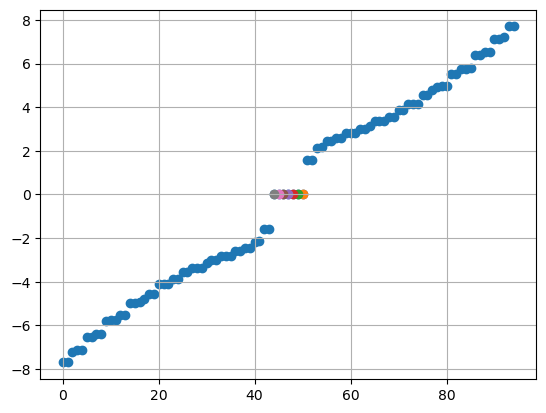

In [12]:
edge_estzz, edge_vecstzz = get_eigen_energies_and_vectors(sys_t_zz.finalized(), 200)
plt.scatter(list(range(len(edge_estzz))), edge_estzz)
plt.scatter(50, edge_estzz[50])
plt.scatter(49, edge_estzz[49])
plt.scatter(48, edge_estzz[48])
plt.scatter(47, edge_estzz[47])
plt.scatter(46, edge_estzz[46])
plt.scatter(45, edge_estzz[45])
plt.scatter(44, edge_estzz[44])
plt.grid()
plt.show()

/home/khaled-hasan/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/khaled-hasan/miniconda3/lib/python3.10/site-packages/matplotlib/collections.py:200: ComplexWarning:

Casting complex values to real discards the imaginary part



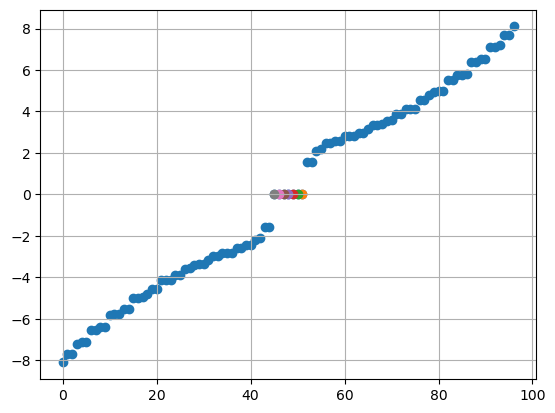

In [13]:
from scipy.linalg import eig
edge_estzz, edge_vecstzz = eig(sys_t_zz.finalized().hamiltonian_submatrix())
asort = np.argsort(edge_estzz)
edge_estzz = edge_estzz[asort]
edge_vecstzz = edge_vecstzz.T
edge_vecstzz = edge_vecstzz[asort]
plt.scatter(list(range(len(edge_estzz))), edge_estzz)
plt.scatter(51, edge_estzz[51])
plt.scatter(50, edge_estzz[50])
plt.scatter(49, edge_estzz[49])
plt.scatter(48, edge_estzz[48])
plt.scatter(47, edge_estzz[47])
plt.scatter(46, edge_estzz[46])
plt.scatter(45, edge_estzz[45])
# plt.scatter(44, edge_estzz[44])
plt.grid()
plt.show()

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 0.95% of values overflowing upper limit 0.76497 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 0.98% of values overflowing upper limit 0.815795 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 1.30% of values overflowing upper limit 0.737255 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 1.30% of values overflowing upper limit 0.676153 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 1.45% of values overflowing upper limit 0.809239 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 1.45% of values overflowing upper limit 0.808179 

/tmp/ipykernel_13441/1929092826.py:7: RuntimeWarning:

The plotted data contains 0.95% of values overflowing upper limit 0.935461 

/home/khaled-hasan/miniconda3/lib/python3.10/site-packages/kwant/plotter.py:1

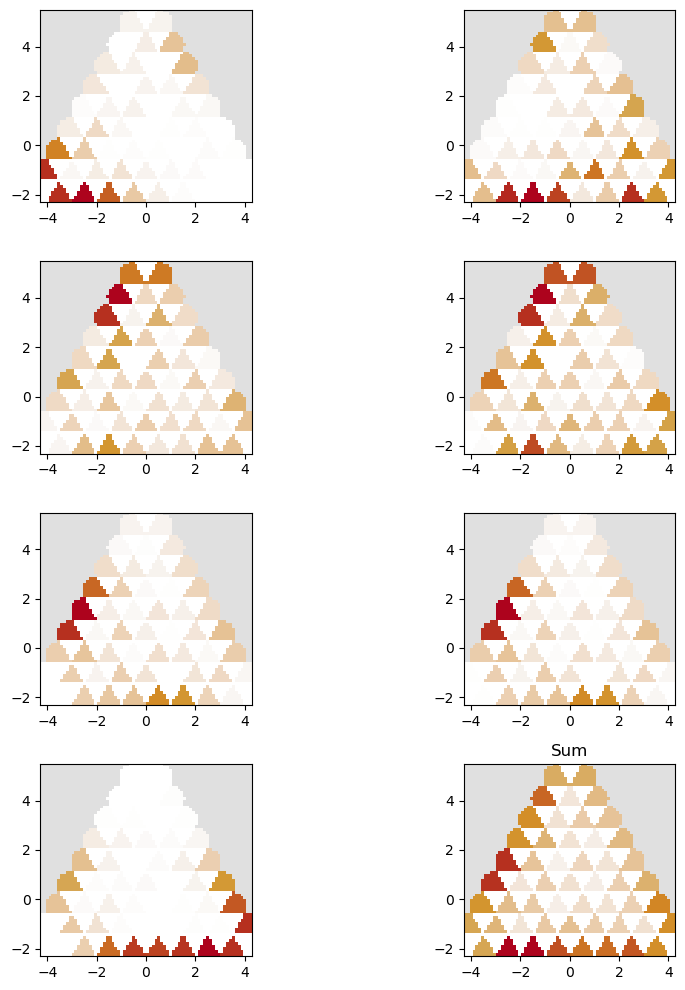

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

sum_vec = np.zeros_like(edge_vecstzz[0])
for ii in range(7):
    normalized_den = np.abs(edge_vecstzz[51 - ii])**2
    normalized_den = normalized_den/normalized_den.max()
    kwant.plotter.map(sys_t_zz.finalized(), normalized_den, oversampling=5, show=False, ax=axs[ii//2, ii%2], colorbar=True)
    sum_vec += np.abs(edge_vecstzz[51 - ii])**2 # this would be kinna questionable (or not, the eigenvalues should have been chosen to be orthogonal)

kwant.plotter.map(sys_t_zz.finalized(), sum_vec/sum_vec.max(), oversampling=5, show=False, ax=axs[7//2, 7%2], colorbar=True)
axs[3, 1].set_title("Sum")

plt.tight_layout()
plt.show()

I think the reason I am missing the books results is due to not ensuring orthogonality

In [21]:
def sorted_eigs(ev, n):
    evals, evecs = ev
    evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
    return evals, evecs.transpose()

def plot_current(syst):
    # Calculate the wave functions in the system.
    ham_mat = syst.hamiltonian_submatrix(sparse=True)
    evals, evecs = sorted_eigs(sla.eigsh(ham_mat.tocsc(), k=20, sigma=0, which="SM"))

    # Calculate and plot the local current of the 10th eigenmode.
    J = kwant.operator.Current(syst)
    print(J)
    current = J(evecs[:, 51])
    kwant.plotter.current(syst, current, colorbar=False)